## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
import sys

!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install --upgrade pandas

    100% |████████████████████████████████| 109.8MB 345kB/s eta 0:00:01 1% |▌                               | 1.8MB 27.1MB/s eta 0:00:04    7% |██▍                             | 8.3MB 36.4MB/s eta 0:00:03    13% |████▎                           | 14.7MB 33.8MB/s eta 0:00:03    15% |█████                           | 17.5MB 27.0MB/s eta 0:00:04    19% |██████▍                         | 21.7MB 31.9MB/s eta 0:00:03    33% |██████████▋                     | 36.4MB 27.9MB/s eta 0:00:03    40% |█████████████                   | 44.4MB 25.2MB/s eta 0:00:03    42% |█████████████▊                  | 46.9MB 27.2MB/s eta 0:00:03    43% |██████████████                  | 48.1MB 26.8MB/s eta 0:00:03    47% |███████████████▏                | 51.9MB 26.5MB/s eta 0:00:03    48% |███████████████▌                | 53.2MB 26.3MB/s eta 0:00:03    54% |█████████████████▋              | 60.2MB 23.0MB/s eta 0:00:03    56% |██████████████████              | 61.6MB 28.4MB/s eta 0:00:02    57% |█████████████████

In [5]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
X_train = train_data.drop('purchase', axis=1)
y_train = train_data['purchase']
X_trainl, X_testl, y_trainl, y_testl = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
train_data.head(20)

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2
5,9,No,0,1,41.189415,-0.905350,2,4,4,1
6,11,No,0,1,40.690409,1.085939,2,2,1,2
7,14,No,0,2,25.971529,-1.424817,1,3,3,2
8,15,Yes,0,2,31.930423,0.393317,2,3,1,2
9,16,No,0,1,27.474650,0.566472,2,2,3,2


In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
print(X_trainl.groupby('Promotion').max())
print()
print(X_trainl.groupby('Promotion').min())
for i in range(4):
    print(X_trainl[X_trainl['V1'] == i].groupby('Promotion')['V1'].count())

               ID  V1         V2        V3  V4  V5  V6  V7
Promotion                                                 
No         126184   3  49.170628  1.691984   2   4   4   2
Yes        126175   3  49.823708  1.691984   2   4   4   2

           ID  V1        V2       V3  V4  V5  V6  V7
Promotion                                           
No          1   0  8.939305 -1.68455   1   1   1   1
Yes         8   0  7.104007 -1.68455   1   1   1   1
Promotion
No     4276
Yes    4252
Name: V1, dtype: int64
Promotion
No     12665
Yes    12563
Name: V1, dtype: int64
Promotion
No     12556
Yes    12779
Name: V1, dtype: int64
Promotion
No     4199
Yes    4337
Name: V1, dtype: int64


In [6]:
print('V4')
print()
for i in [1, 2]:
    print(X_trainl[X_trainl['V4'] == i].groupby('Promotion')['V1'].count())
print()
print('V5')
print()
for i in [1, 2, 3, 4]:
    print(X_trainl[X_trainl['V5'] == i].groupby('Promotion')['V1'].count())
print()
print('V6')
print()
for i in [1, 2, 3, 4]:
    print(X_trainl[X_trainl['V6'] == i].groupby('Promotion')['V1'].count())
print()
print('V7')
print()
for i in [1, 2]:
    print(X_trainl[X_trainl['V7'] == i].groupby('Promotion')['V1'].count())
print()

V4

Promotion
No     10787
Yes    10917
Name: V1, dtype: int64
Promotion
No     22909
Yes    23014
Name: V1, dtype: int64

V5

Promotion
No     6122
Yes    6230
Name: V1, dtype: int64
Promotion
No     12422
Yes    12531
Name: V1, dtype: int64
Promotion
No     13045
Yes    13132
Name: V1, dtype: int64
Promotion
No     2107
Yes    2038
Name: V1, dtype: int64

V6

Promotion
No     8398
Yes    8428
Name: V1, dtype: int64
Promotion
No     8412
Yes    8485
Name: V1, dtype: int64
Promotion
No     8400
Yes    8500
Name: V1, dtype: int64
Promotion
No     8486
Yes    8518
Name: V1, dtype: int64

V7

Promotion
No     10028
Yes    10091
Name: V1, dtype: int64
Promotion
No     23668
Yes    23840
Name: V1, dtype: int64



In [7]:
x_V2_0 = X_trainl[X_trainl['Promotion'] == 'No']['V2']
x_V2_1 = X_trainl[X_trainl['Promotion'] == 'Yes']['V2']
x_V3_0 = X_trainl[X_trainl['Promotion'] == 'No']['V3']
x_V3_1 = X_trainl[X_trainl['Promotion'] == 'Yes']['V3']

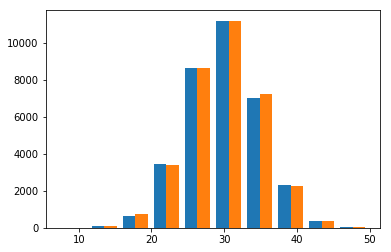

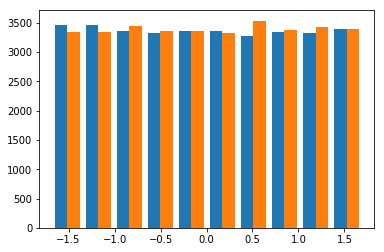

In [8]:
plt.hist([x_V2_0, x_V2_1])
plt.show()
plt.hist([x_V3_0, x_V3_1])
plt.show()

### Initial Thoughts

These could (possibly) be 4 distinct groups. V1 is not a count. If you look at the groups, it's 1:3:3:1 0:1:2:3 and evenly split across all 4 categories into promotion or no promotion. It's an even split across all integer categories, in fact, and we'll pull histograms on V2 and V3 soon to check that as well. Truly, a little remarkable? Could I construct such a split myself? I'd have to think about it. Anway, we're looking at:
* V4 - 1:2
* V5 - 3:6:6:1
* V6 - 1:1:1:1
* V7 - More significantly under 1:2, 2.5:6

Of course, this doesn't mean the people in each group are similar! If they were randomly selected, we would expect that, but it's possible that the covariance is totally different in each group. I'll be much more comfortable if that isn't the case.

To the floats! V2 varies between ~7 and ~50, so it's not normalized, but it could be! I'm not saying it's normal, but it's not not normal, so it seems like subtracting the mean and dividing by the standard deviation could serve us well. On the other hand, look at V3! That's uniform, -1.69 to 1.69. Both are split evenly across promotion and no promotion

In [6]:
local_train_data = pd.concat([X_trainl, y_trainl], axis=1)
promotion = local_train_data[local_train_data['Promotion'] == 'Yes']
no_promotion = local_train_data[local_train_data['Promotion'] == 'No']

In [10]:
promotion.cov()

,ID,V1,V2,V3,V4,V5,V6,V7,purchase
ID,1.324028e+09,-10.101113,308.513951,19.223899,-174.470579,22.129674,-204.736291,33.557369,17.591136
V1,-1.010111e+01,0.756237,-0.019343,0.011560,0.001570,-0.002953,-0.003411,0.000753,-0.000797
V2,3.085140e+02,-0.019343,25.237514,-0.025316,-0.004497,-0.035303,-0.011452,-0.006197,-0.001426
V3,1.922390e+01,0.011560,-0.025316,0.995334,0.000459,-0.000068,0.009636,-0.000490,-0.002636
V4,-1.744706e+02,0.001570,-0.004497,0.000459,0.218230,-0.001118,-0.003379,-0.000197,0.003289
V5,2.212967e+01,-0.002953,-0.035303,-0.000068,-0.001118,0.706224,0.002679,0.001881,0.001484
V6,-2.047363e+02,-0.003411,-0.011452,0.009636,-0.003379,0.002679,1.248870,0.000144,-0.000367
V7,3.355737e+01,0.000753,-0.006197,-0.000490,-0.000197,0.001881,0.000144,0.208958,-0.000339
purchase,1.759114e+01,-0.000797,-0.001426,-0.002636,0.003289,0.001484,-0.000367,-0.000339,0.016802


In [11]:
no_promotion.cov()

,ID,V1,V2,V3,V4,V5,V6,V7,purchase
ID,1.337323e+09,-337.162240,-458.015436,227.407016,-112.268569,90.249522,80.438815,126.217616,27.964794
V1,-3.371622e+02,0.753024,-0.007855,-0.000233,0.001872,0.001029,-0.003513,0.001644,-0.000704
V2,-4.580154e+02,-0.007855,24.967944,0.006897,0.027902,0.022562,-0.059488,-0.002070,-0.001152
V3,2.274070e+02,-0.000233,0.006897,1.007786,0.003506,-0.003081,0.000810,0.000670,0.000206
V4,-1.122686e+02,0.001872,0.027902,0.003506,0.217652,0.001877,0.002636,-0.000868,0.000109
V5,9.024952e+01,0.001029,0.022562,-0.003081,0.001877,0.709721,-0.008195,0.001703,0.000407
V6,8.043882e+01,-0.003513,-0.059488,0.000810,0.002636,-0.008195,1.252160,0.002241,-0.000147
V7,1.262176e+02,0.001644,-0.002070,0.000670,-0.000868,0.001703,0.002241,0.209041,0.000030
purchase,2.796479e+01,-0.000704,-0.001152,0.000206,0.000109,0.000407,-0.000147,0.000030,0.007423


In [12]:
X_trainl.cov()

,ID,V1,V2,V3,V4,V5,V6,V7
ID,1.330658e+09,-174.021728,-73.659014,121.588838,-143.346123,56.629598,-62.680219,79.708925
V1,-1.740217e+02,0.754661,-0.013610,0.005735,0.001716,-0.000990,-0.003460,0.001198
V2,-7.365901e+01,-0.013610,25.102829,-0.009252,0.011645,-0.006477,-0.035386,-0.004141
V3,1.215888e+02,0.005735,-0.009252,1.001596,0.001971,-0.001599,0.005240,0.000089
V4,-1.433461e+02,0.001716,0.011645,0.001971,0.217940,0.000377,-0.000382,-0.000531
V5,5.662960e+01,-0.000990,-0.006477,-0.001599,0.000377,0.707968,-0.002740,0.001792
V6,-6.268022e+01,-0.003460,-0.035386,0.005240,-0.000382,-0.002740,1.250491,0.001189
V7,7.970893e+01,0.001198,-0.004141,0.000089,-0.000531,0.001792,0.001189,0.208997


Alright! So we can say, at a casual level, that everything works out. I might run a full set of pairwise distribution checks just to flag anything totally out of line? I really don't want to get burned by this later, and there are only so many variables. Let's do it.

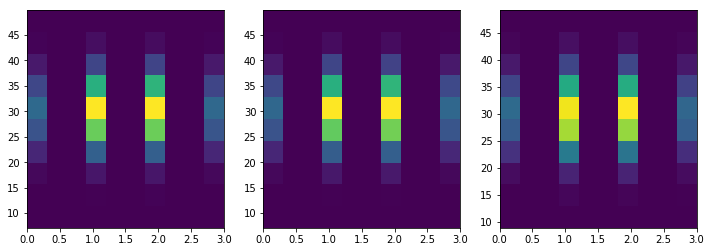

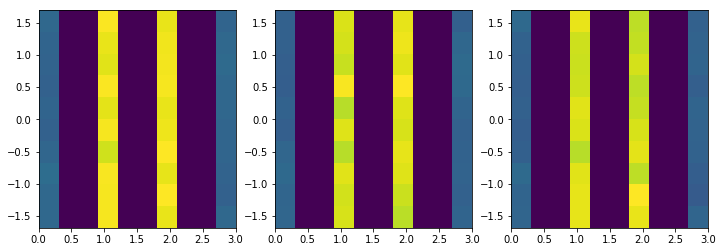

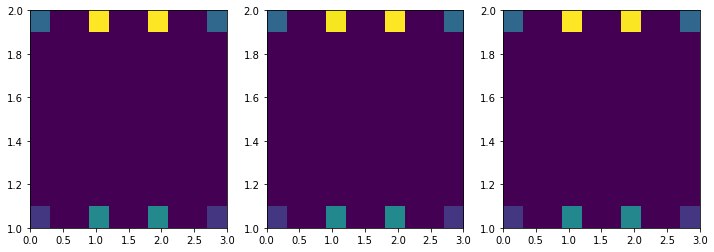

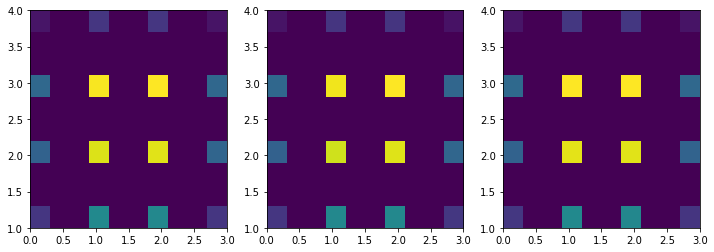

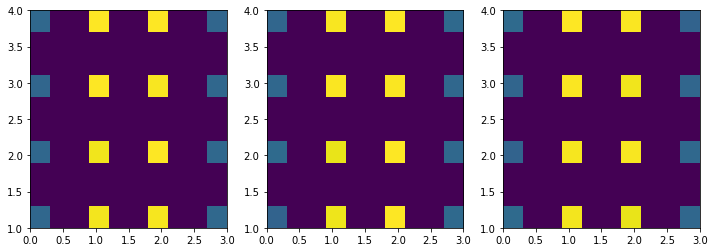

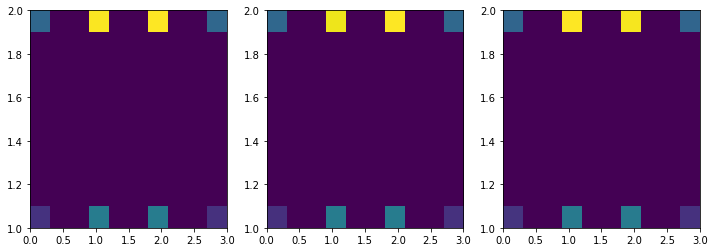

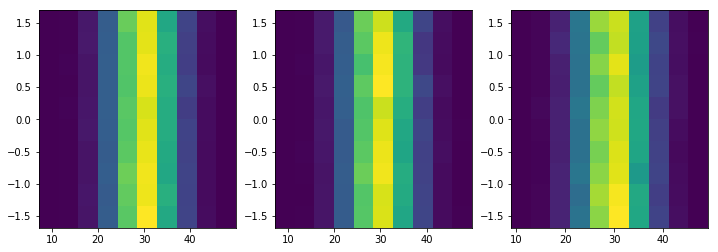

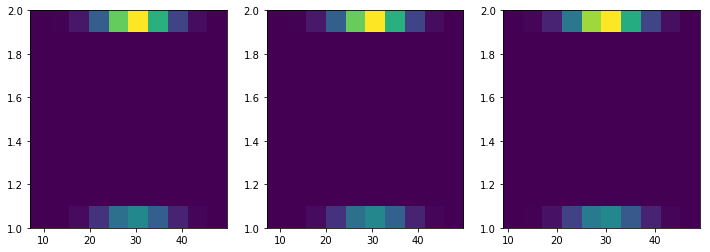

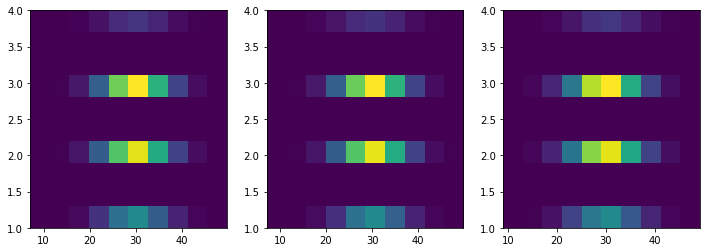

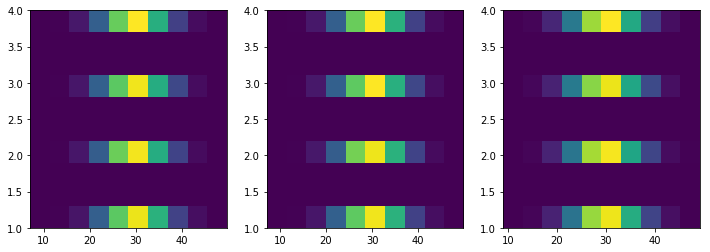

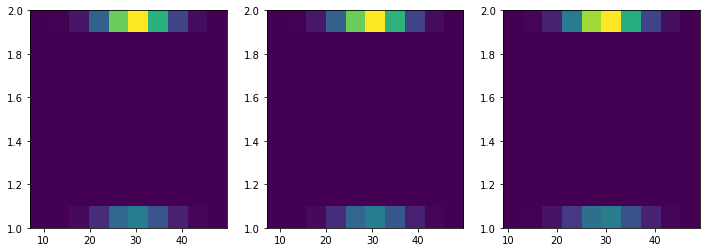

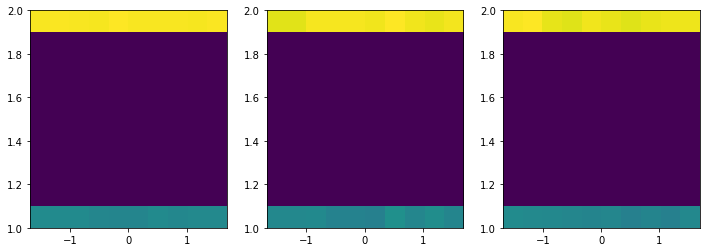

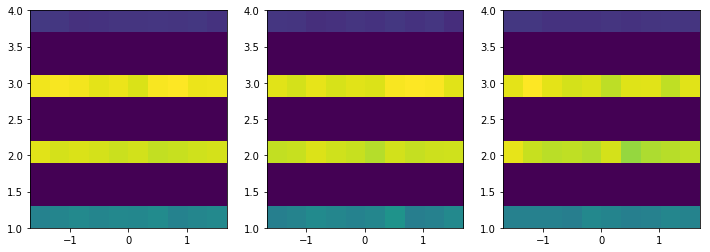

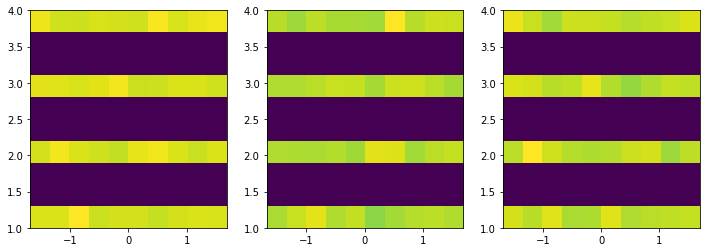

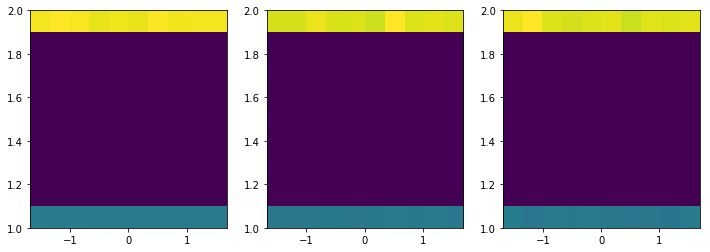

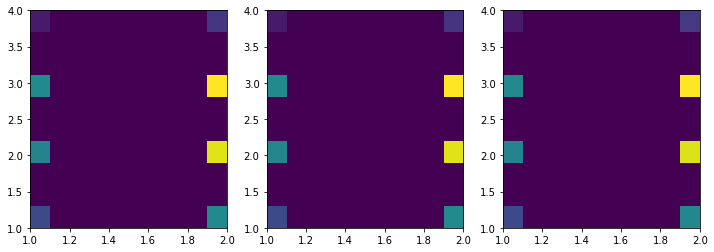

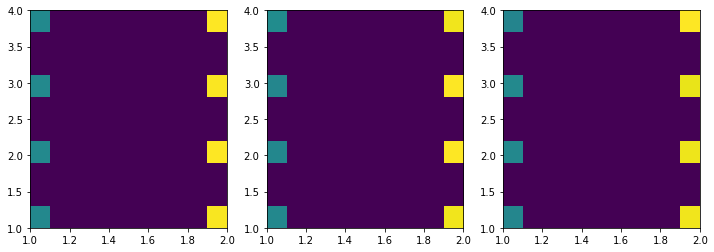

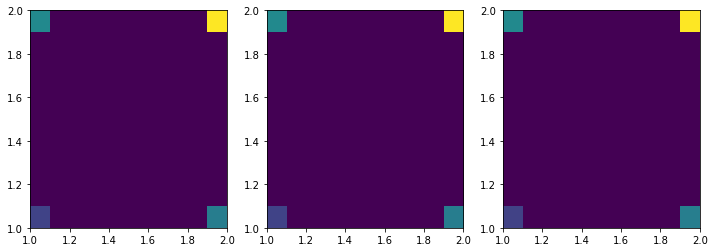

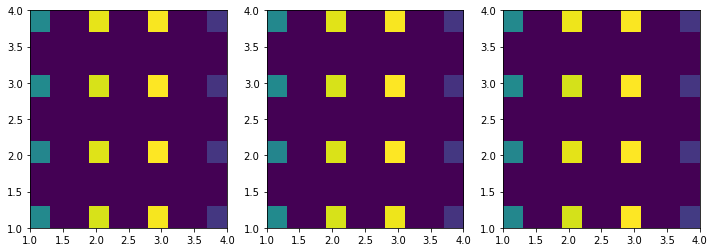

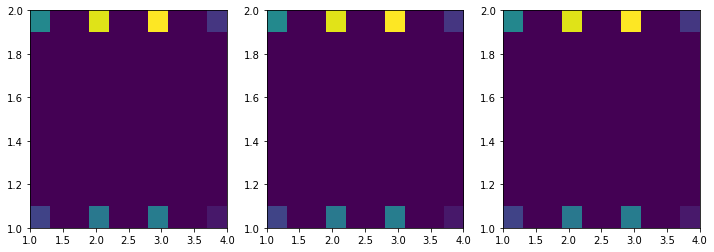

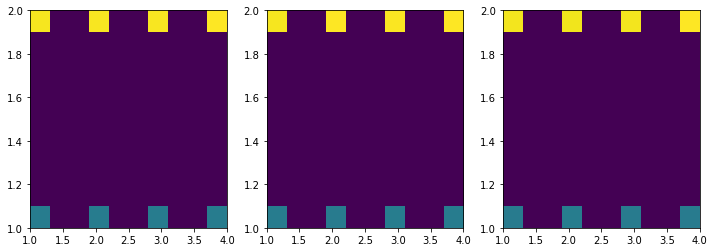

In [10]:
for var1 in range(7):
    for var2 in range(var1 + 1, 7):
        v1 = "V{}".format(var1 + 1)
        v2 = "V{}".format(var2 + 1)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(12, 4)
        ax1.hist2d(X_trainl[v1], X_trainl[v2])
        ax2.hist2d(promotion[v1], promotion[v2])
        ax3.hist2d(no_promotion[v1], no_promotion[v2])
        plt.show()

Now that's a great set of charts. I'm now totally comfortable assuming that the population given the promotion initially has the same demographics as the population not given the promotion, which just makes everything a lot easier. So let's talk about the basics of the promotion: indiscriminately applied, how much of an effect does the promotion have and how cost effective is it?

In [7]:
def inc_resp_rate(control_response, experimental_response):
    '''
    INPUT
    control_response - a pandas series of binary data indicating
                       whether or not a purchase was made
                       for the control group
    experimental_response - the above for the experimental group
    
    OUTPUT:
    irr - the incremental response rate, p(purchase_exp) - p(purchase_ctrl)
    p - an estimate of the significance of the difference, assuming a binomial variable
    '''
    n0 = control_response.size
    n1 = experimental_response.size
    n = n0 + n1
    num_0 = control_response.sum()
    num_1 = experimental_response.sum()
    num = num_0 + num_1
    p0 = num_0 / n0
    p1 = num_1 / n1
    p_hat = num / n
    denom = np.sqrt(p_hat * (1 - p_hat) * (1. / n0 + 1. / n1))
    if denom == 0:
        return p1 - p0, -1
    z = (p1 - p0) / denom
    p_val = sp.stats.norm.sf(z) # one-sided p test
    return p1 - p0, p_val

In [17]:
inc_resp_rate(no_promotion['purchase'], promotion['purchase'])

(0.009614880827783483, 4.102046618162408e-30)

Incredibly effective! The purchases more than doubled, and we find it hard to deny the effect. What about our net incremental revenue?

In [9]:
def nir(control_response, experimental_response):
    '''
    INPUT
    control_response - a pandas series of binary data indicating
                       whether or not a purchase was made
                       for the control group
    experimental_response - the above for the experimental group
    
    OUTPUT:
    nir - the net incremental revenue, experimental earnings minus intervention
          cost and control earnings
    '''
    epc = 10. # Earnings per customer
    cost = 0.15 # Cost of intervention
    total_cost = cost * experimental_response.size
    nir = epc * experimental_response.sum() - epc * control_response.sum() - total_cost
    return nir

In [19]:
nir(no_promotion['purchase'], promotion['purchase'])

-1809.6499999999996

Now this will work initially because I have the same amount in control and treated. However, surely this isn't really the desired formula? We should maximize (irr * earnings - intervention_cost) * experimental_population_size. Still, it's clear that we need to do some targeting. $2000 is a decent price for an 80,000 person experiment, but that number has to be positive for this to matter at all. Let's check my metric just to be sure they're comparable in the base case

In [10]:
def my_nir(control_response, experimental_response):
    '''
    INPUT
    control_response - a pandas series of binary data indicating
                       whether or not a purchase was made
                       for the control group
    experimental_response - the above for the experimental group
    
    OUTPUT:
    nir - the net incremental revenue, experimental earnings minus intervention
          cost and control earnings
    '''
    
    epc = 10.
    cost = 0.15
    irr, _ = inc_resp_rate(control_response, experimental_response)
    nir = (irr * epc - cost) * experimental_response.size
    return nir

In [11]:
my_nir(no_promotion['purchase'], promotion['purchase'])

-1827.2247863247858

In [22]:
promotion.shape[0] * 0.15

5089.65

Good. That should work better. Now, we have a clear path forward: If we can identify groups to target (seems likely), then this could be a worthwhile advertising strategy. It clearly has an effect. However, if we can't, it's not worthwhile. We should start with some basic models and see what we get. On the one hand, this is a classification problem. It could be worth looking at it as regression first, though, since that's relatively fine. We also want to distinguish the incremental effect: Which groups are most affected by the advertisement. That's somewhat annoying to shake out with a regression, actually? Or anything. So what data should we be looking at? We want to target the people with the biggest change in behavior due to the advertisement. An uncorrelated model doesn't exactly help that, but a basic start might just be the difference in coefficients. Essentially, we build a model to predict purchases based on no-promotion, a model to predict purchases based on promotion, and then we evaluate based on that group. You need at least a 1.5% irr within the group for it to be worthwhile. Those are independent pieces of the task, right? We train two of the best models we can (Probably the same pipeline twice), and then we train a classifier that maximizes net incremental revenue. So we want something that outputs... probability of purchase. That's what we're training, right? And then we could have a very simple classifier based on that. Or we train a complex classifier, and we tell it exactly what it's trying to predict. Let's just check out linear regression, and also 

In [12]:
def transform_for_regression(data, cat_cols):
    data = data.copy()
    cats = pd.get_dummies(data.loc[:, cat_cols], drop_first=True, columns=cat_cols)
    data = data.drop(cat_cols, axis=1)
    data['V2'] = (data['V2'] - data['V2'].mean()) / data['V2'].std()
    data = pd.concat([data, cats], axis=1)
    return data

In [13]:
cat_cols = ['V1', 'V4', 'V5', 'V6', 'V7'] # Is V1 categorical? I guess fit two models and find out
# Oof. I need a better way to tell, but let's just say it is for now
X_trainl_p = promotion.drop("purchase", axis=1)
y_trainl_p = promotion["purchase"]
X_trainl_np = no_promotion.drop("purchase", axis=1)
y_trainl_np = no_promotion["purchase"]
promote_reg = transform_for_regression(X_trainl_p, cat_cols)
no_promote_reg = transform_for_regression(X_trainl_np, cat_cols)

In [23]:
x_0 = no_promote_reg.drop(["ID", "Promotion"], axis=1)
x_1 = promote_reg.drop(["ID", "Promotion"], axis=1)
y_0 = y_trainl_np
y_1 = y_trainl_p
lrm_0 = LinearRegression()
lrm_1 = LinearRegression()
lrm_0.fit(x_0, y_0)
lrm_1.fit(x_1, y_1)
print(lrm_0.score(x_0, y_0))
print(lrm_1.score(x_1, y_1))
print(lrm_0.score(x_1, y_1))
print(lrm_1.score(x_0, y_0))

0.000218474663609
0.00537786992968
-0.00563702711665
-0.0248914896759


In [24]:
x_0 = no_promote_reg.drop(["ID", "Promotion"], axis=1)
x_1 = promote_reg.drop(["ID", "Promotion"], axis=1)
y_0 = y_trainl_np
y_1 = y_trainl_p
xlr_0 = xgb.XGBRegressor(booster='gblinear')
xlr_1 = xgb.XGBRegressor(booster='gblinear')
xlr_0.fit(x_0, y_0)
xlr_1.fit(x_1, y_1)
print(xlr_0.score(x_0, y_0))
print(xlr_1.score(x_1, y_1))
print(xlr_0.score(x_1, y_1))
print(xlr_1.score(x_0, y_0))

-0.0019810467748
0.00434821134957
-0.00557026457571
-0.0295927720017


[-0.00023977  0.00019412 -0.00607135 -0.00780947 -0.00837582 -0.00184073
 -0.00381841 -0.00407031 -0.00266728 -0.00337712 -0.00472639 -0.00395639
 -0.00333314]
[-0.00028632 -0.00263419 -0.00957941 -0.00695597 -0.0133398   0.0127037
 -0.0148613  -0.00336298 -0.00659561 -0.00593357 -0.00345325 -0.00571308
 -0.00523173]


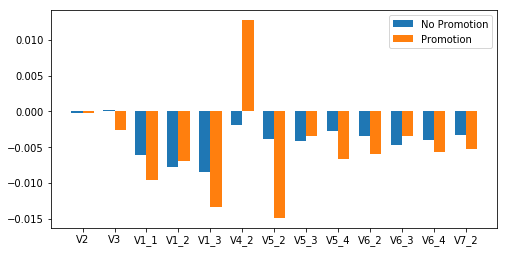

In [25]:
print(xlr_0.coef_)
print(xlr_1.coef_)
fig, ax = plt.subplots()
labels = x_0.columns
x = np.arange(len(labels))
width = 0.35
ax.bar(x= x - width/2, height=xlr_0.coef_, width=width, label='No Promotion')
ax.bar(x= x + width/2, height=xlr_1.coef_, width=width, label='Promotion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.set_size_inches((8, 4))
plt.show()

This is called "Just for fun!" So let's take the most basic strategy, from this truly terrible guessing game. It's called: Pick everyone with V4 = 2 and V5 != 2. A naive strategy to benchmark against? We'll see if it hits positive.

In [23]:
truly_naive_0 = no_promotion[(no_promotion['V4'] == 2) & (no_promotion['V5'] != 2)]
truly_naive_1 = promotion[(promotion['V4'] == 2) & (promotion['V5'] != 2)]
print(my_nir(truly_naive_0['purchase'], truly_naive_1['purchase']))

752.1247499137635


In [24]:
cost = 0.15
print(truly_naive_1.shape)
truly_naive_1.shape[0] * cost

(14511, 10)


2176.65

In [25]:
print(inc_resp_rate(truly_naive_0['purchase'], truly_naive_1['purchase']))

(0.02018313520717913, 5.049452558369499e-39)


Note: This is a substantial improvement, and we hit a positive level! Since this is very inexact, we're pretty interested in outlay. We spent $2176, we reached out to almost 15000 people and we made $750, or about 5 cents a person. That's... pretty good if true? I mean it's obviously not true. But getting 5 cents off of 1/3 of Starbucks customers is a surprisingly good baseline for a garbage model. So we're in!

## Model 1

Take all customers with V4 == 2 and V5 != 2. We reach 1/3 of customers, and we're solid on training set metrics. In fact, I'm going to do this on my local test set, because it's basic and I'm done iterating on this level of model. Hold for results

In [26]:
X_testl.head()
naive_tester = pd.concat([X_testl, y_testl], axis=1)
truly_naive_test_exp = naive_tester[(naive_tester['Promotion'] == 'Yes') & (naive_tester['V4'] == 2) & (naive_tester['V5'] != 2)]
truly_naive_test_cont = naive_tester[(naive_tester['Promotion'] == 'No') & (naive_tester['V4'] == 2) & (naive_tester['V5'] != 2)]

cost = 0.15

print(my_nir(truly_naive_test_cont['purchase'], truly_naive_test_exp['purchase']))
print(inc_resp_rate(truly_naive_test_cont['purchase'], truly_naive_test_exp['purchase']))
print(truly_naive_test_exp.shape)
print(truly_naive_test_exp.shape[0] * cost)

134.49044321329643
(0.01862215036933198, 8.026165577571097e-10)
(3713, 10)
556.9499999999999


In [30]:
134.490443213 * 14511 / 3713

525.6102400926052

In [31]:
134.49 / 556.95

0.24147589550228926

So we're about 2/3 efficacy on the remainder of the training set, which was not influencing this decision at all. Let's call that 3 cents a customer, for what is still roughly 1/3 of the customer base. We're no longer making up losses in volume! Of course, I don't actually know how customers were selected for this trial. It seems highly possible that these people were chosen in a particular portion, but it is at least possible that this promotion could be profitably sent out to a large number of people. 40% losses to 25% profits! But we can do better (I hope)

## Model 2

Include anyone whose prediction from lrm_1 is 0.015 greater than their prediction from lrm_0.

In [32]:
x_1.apply(lambda row: lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)), axis=1).apply(lambda x: 1 if x > 0.015 else 0).sum()

11477

In [33]:
naive_2_bools = x_1.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1).apply(lambda x: x > 0.015)

In [34]:
naive_2 = promotion[naive_2_bools.values]

In [35]:
cost = 0.15

print(naive_2['purchase'].sum() / naive_2.shape[0])
print(no_promotion['purchase'].sum() / no_promotion.shape[0])

print(my_nir(no_promotion['purchase'], naive_2['purchase']))
print(inc_resp_rate(no_promotion['purchase'], naive_2['purchase']))
print(naive_2.shape)
print(naive_2.shape[0] * cost)

0.0298858586739
0.00747863247863
850.127350427
(0.022407226195236999, 3.3957470530543185e-74)
(11477, 10)
1721.55


So there's the obvious concern: Interpreting the number as a percent is meaningless, yeah? However, I pose to you an equally obvious response: Sort by the difference, plot cutoff value or number of points vs nir (or irr, or both)

In [36]:
promotion.loc[:, 'lin_reg_diff'] = x_1.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
no_promotion.loc[:, 'lin_reg_diff'] = x_0.apply(lambda row: (lrm_1.predict(row.values.reshape(1, -1)) - lrm_0.predict(row.values.reshape(1, -1)))[0], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
sorted_vals = promotion[['purchase', 'lin_reg_diff']].sort_values(by='lin_reg_diff')
sorted_controls = no_promotion[['purchase', 'lin_reg_diff']].sort_values(by='lin_reg_diff')

x_0s = sorted_controls['lin_reg_diff'].values
y_0s = sorted_controls['purchase'].values
x_1s = sorted_vals['lin_reg_diff'].values
y_1s = sorted_vals['purchase'].values

In [39]:
x_0s.size

33696

In [40]:
x_1s.size

33931

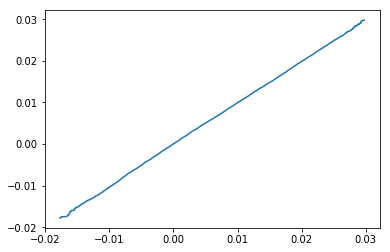

In [41]:
plt.plot(x_0s, sorted(np.random.choice(x_1s, x_0s.size)))

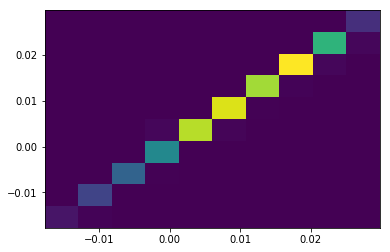

In [42]:
plt.hist2d(x_0s, sorted(np.random.choice(x_1s, x_0s.size)))
plt.show()

As you can see, it's reasonable to run a selection on the control group to get an accurate incremental response rate

In [43]:
data_nir = np.zeros(y_1s.size)
data_irr = np.zeros(y_1s.size)
control_idx = 0
for i in range(y_1s.size):
    while control_idx < y_0s.size - 1 and x_0s[control_idx] < x_1s[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(y_0s[control_idx:], y_1s[i:])
    data_nir[i] = my_nir(y_0s[control_idx:], y_1s[i:])

(array([ 1257.,  2296.,  1550.,  1671.,  1524.,  1466.,  2318.,  4809.,
         7241.,  9799.]),
 array([-1827.22478632, -1552.88118185, -1278.53757738, -1004.19397291,
         -729.85036844,  -455.50676397,  -181.1631595 ,    93.18044497,
          367.52404944,   641.86765391,   916.21125838]),
 <a list of 10 Patch objects>)

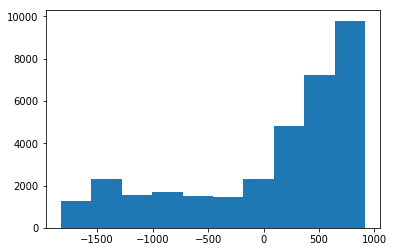

In [44]:
plt.hist(data_nir)

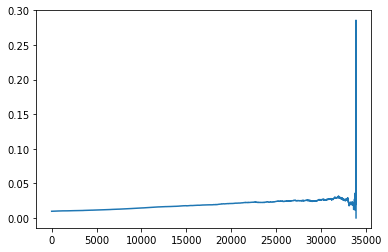

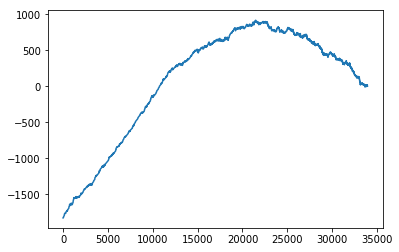

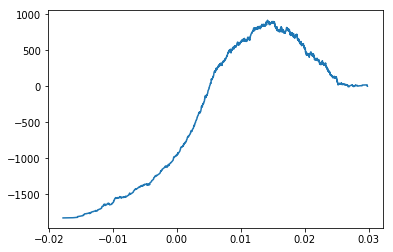

In [45]:
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(x_1s, data_nir)
plt.show()

In [46]:
promotion.loc[:, 'xgb_reg_diff'] = x_1.apply(lambda row: (xlr_1.predict(row.values.reshape(1, -1), validate_features=False) - xlr_0.predict(row.values.reshape(1, -1), validate_features=False))[0], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
no_promotion.loc[:, 'xgb_reg_diff'] = x_0.apply(lambda row: (xlr_1.predict(row.values.reshape(1, -1), validate_features=False) - xlr_0.predict(row.values.reshape(1, -1), validate_features=False))[0], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [48]:
sorted_vals = promotion[['purchase', 'xgb_reg_diff']].sort_values(by='xgb_reg_diff')
sorted_controls = no_promotion[['purchase', 'xgb_reg_diff']].sort_values(by='xgb_reg_diff')

xg_0s = sorted_controls['xgb_reg_diff'].values
yg_0s = sorted_controls['purchase'].values
xg_1s = sorted_vals['xgb_reg_diff'].values
yg_1s = sorted_vals['purchase'].values

In [49]:
xg_0s.size

33696

In [50]:
xg_1s.size

33931

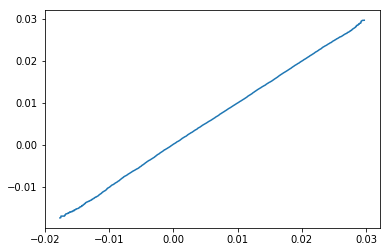

In [51]:
plt.plot(xg_0s, sorted(np.random.choice(xg_1s, xg_0s.size)))

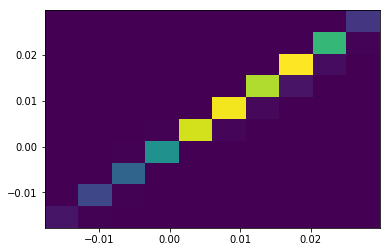

In [52]:
plt.hist2d(xg_0s, sorted(np.random.choice(xg_1s, xg_0s.size)))
plt.show()

As you can see, it's reasonable to run a selection on the control group to get an accurate incremental response rate

In [53]:
data_nir = np.zeros(yg_1s.size)
data_irr = np.zeros(yg_1s.size)
control_idx = 0
for i in range(yg_1s.size):
    while control_idx < yg_0s.size - 1 and xg_0s[control_idx] < xg_1s[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(yg_0s[control_idx:], yg_1s[i:])
    data_nir[i] = my_nir(yg_0s[control_idx:], yg_1s[i:])

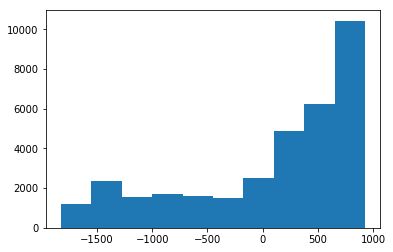

In [54]:
plt.hist(data_nir)
plt.show()

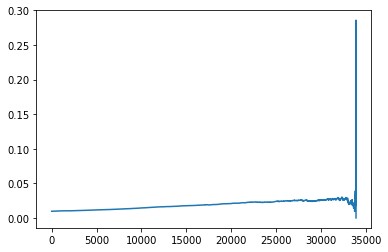

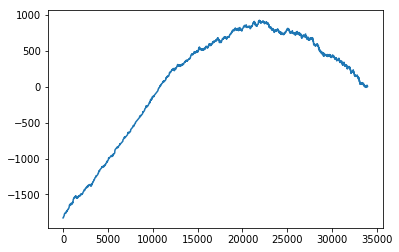

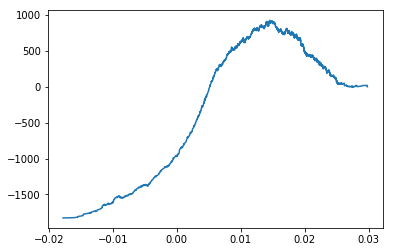

In [55]:
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(x_1s, data_nir)
plt.show()

...I mean I'm not saying it's a probability, but is it too much to say this is a strong argument in favor of it being a probablity? It's not, right? That's a solid experimental graph right there, and it held out for the test set. This we will call "Strongly in favor of naive_2 as a model." The basic idea is that OLS linear regression is an unbiased estimator of the mean, and the mean of a binary variable is the fraction of 1s. So we're maximizing expected revenue by only sending messages to potential customers if the expected value is positive. I like it a lot! But shouldn't we be able to do this with logistic regression?

Something was weird!

Alright, so this is obviously ("") superior, if we're not overfitting. I'll check this on test too, just to get a sense of how much we might be, but otherwise I'm currently in favor of building two best-fit models, applying both to the problem, and sending a promotion if the expected value is positive. Let's call this a workable model: We don't actually want to classify here, we want to do a regression on the rate of purchase. Actually, before I move to any testing data, let's set up an actual pipeline for doing cross-validation on regression models, since I'm all for it. We can even have a parameter for categorical columns to see whether we should be treating V1 as categorical (although my intuition is still yes)

## Model 3

Let's see if we can handle the balance problem in logistic regression. If not, we'll go to model 4, a clean pipeline with some grid search on feature engineering for linear regression, since I'm satisfied with the theoretical background and the performance.

In [ ]:
x_0 = no_promote_reg.drop(["ID", "Promotion"], axis=1)
x_1 = promote_reg.drop(["ID", "Promotion"], axis=1)
y_0 = y_trainl_np
y_1 = y_trainl_p
rrm_0 = LogisticRegression(class_weight='balanced')
rrm_1 = LogisticRegression(class_weight='balanced')
rrm_0.fit(x_0, y_0)
rrm_1.fit(x_1, y_1)
print(rrm_0.score(x_0, y_0))
print(rrm_1.score(x_1, y_1))
print(rrm_0.score(x_1, y_1))
print(rrm_1.score(x_0, y_0))

In [ ]:
print(rrm_0.coef_[0])
print(rrm_1.coef_[0])
fig, ax = plt.subplots()
labels = x_0.columns
x = np.arange(len(labels))
width = 0.35
ax.bar(x= x - width/2, height=rrm_0.coef_[0], width=width, label='No Promotion')
ax.bar(x= x + width/2, height=rrm_1.coef_[0], width=width, label='Promotion')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.set_size_inches((8, 4))
plt.show()

In [ ]:
model_3_bools = x_1.apply(lambda row: (xlr_1.predict(row.values.reshape(1, -1), validate_features=False) - xlr_0.predict(row.values.reshape(1, -1), validate_features=False))[0], axis=1).apply(lambda x: x > 0.015)

In [ ]:
model_3_exp =  x_1.apply(lambda row: xlr_1.predict(row.values.reshape(1, -1), validate_features=False)[0], axis=1)
model_3_cont =  x_1.apply(lambda row: xlr_0.predict(row.values.reshape(1, -1), validate_features=False)[0], axis=1)

In [ ]:
model_3_exp.describe()

In [ ]:
model_3_cont.describe()

In [ ]:
print(model_3_bools.sum())

In [ ]:
model_3 = promotion[model_3_bools]
cost = 0.15

print(model_3.head())

print(model_3['purchase'].sum() / model_3.shape[0])
print(no_promotion['purchase'].sum() / no_promotion.shape[0])

print(my_nir(no_promotion['purchase'], model_3['purchase']))
print(inc_resp_rate(no_promotion['purchase'], model_3['purchase']))
print(model_3.shape)
print(model_3.shape[0] * cost)

In [ ]:
promotion.loc[:, 'log_reg_diff'] = x_1.apply(lambda row: (rrm_1.predict_proba(row.values.reshape(1, -1)) - rrm_0.predict_proba(row.values.reshape(1, -1)))[0][1], axis=1)

In [ ]:
no_promotion.loc[:, 'log_reg_diff'] = x_0.apply(lambda row: (rrm_1.predict_proba(row.values.reshape(1, -1)) - rrm_0.predict_proba(row.values.reshape(1, -1)))[0][1], axis=1)

In [ ]:
promotion.head()

In [ ]:
sorted_vals = promotion[['purchase', 'log_reg_diff']].sort_values(by='log_reg_diff')
sorted_controls = no_promotion[['purchase', 'log_reg_diff']].sort_values(by='log_reg_diff')

x3_0s = sorted_controls['log_reg_diff'].values
y3_0s = sorted_controls['purchase'].values
x3_1s = sorted_vals['log_reg_diff'].values
y3_1s = sorted_vals['purchase'].values

In [ ]:
x3_0s.size

In [ ]:
x3_1s.size

In [ ]:
plt.plot(x3_0s, sorted(np.random.choice(x3_1s, x3_0s.size)))

In [ ]:
plt.hist2d(x3_0s, sorted(np.random.choice(x3_1s, x3_0s.size)))

As you can see, it's reasonable to run a selection on the control group to get an accurate incremental response rate

In [ ]:
data3_nir = np.zeros(y3_1s.size)
data3_irr = np.zeros(y3_1s.size)
control_idx = 0
for i in range(y3_1s.size):
    while control_idx < y3_0s.size - 1 and x3_0s[control_idx] < x3_1s[i]:
        control_idx += 1
    data3_irr[i], _ = inc_resp_rate(y3_0s[control_idx:], y3_1s[i:])
    data3_nir[i] = my_nir(y3_0s[control_idx:], y3_1s[i:])

In [ ]:
plt.hist(data3_nir)

In [ ]:
plt.plot(data3_irr)
plt.show()
plt.plot(data3_nir)
plt.show()
plt.plot(x3_1s, data3_nir)
plt.show()

In [ ]:
plt.plot(x3_1s[15000:25000], data3_nir[15000:25000])
plt.show()

In [ ]:
cost = 0.15

just_2_ctrl = no_promotion[no_promotion['lin_reg_diff'] > 0.015]['purchase']
just_2_exp = promotion[promotion['lin_reg_diff'] > 0.015]['purchase']

print(just_2_exp.sum() / just_2_exp.size)
print(just_2_ctrl.sum() / just_2_ctrl.size)

print(my_nir(just_2_ctrl, just_2_exp))
print(inc_resp_rate(just_2_ctrl, just_2_exp))
print(just_2_exp.size)
print(just_2_exp.size * cost)

In [ ]:
cost = 0.15

just_3_ctrl = no_promotion[no_promotion['log_reg_diff'] > 0.015]['purchase']
just_3_exp = promotion[promotion['log_reg_diff'] > 0.015]['purchase']

print(just_3_exp.sum() / just_3_exp.size)
print(just_3_ctrl.sum() / just_3_ctrl.size)

print(my_nir(just_3_ctrl, just_3_exp))
print(inc_resp_rate(just_3_ctrl, just_3_exp))
print(just_3_exp.size)
print(just_3_exp.size * cost)

In [ ]:
cost = 0.15

both_ctrl = no_promotion[(no_promotion['lin_reg_diff'] > 0.015) & (no_promotion['log_reg_diff'] > 0.015)]['purchase']
both_exp = promotion[(promotion['lin_reg_diff'] > 0.015) & (promotion['log_reg_diff'] > 0.015)]['purchase']

print(both_exp.sum() / both_exp.size)
print(both_ctrl.sum() / both_ctrl.size)

print(my_nir(both_ctrl, both_exp))
print(inc_resp_rate(both_ctrl, both_exp))
print(both_exp.size)
print(both_exp.size * cost)

In [ ]:
cost = 0.15

either_ctrl = no_promotion[(no_promotion['lin_reg_diff'] > 0.015) | (no_promotion['log_reg_diff'] > 0.015)]['purchase']
either_exp = promotion[(promotion['lin_reg_diff'] > 0.015) | (promotion['log_reg_diff'] > 0.015)]['purchase']

print(either_exp.sum() / either_exp.size)
print(either_ctrl.sum() / either_ctrl.size)

print(my_nir(either_ctrl, either_exp))
print(inc_resp_rate(either_ctrl, either_exp))
print(either_exp.size)
print(either_exp.size * cost)

Balancing the class weights is key, as is using probability prediction. But in practice, we're looking at that flat region, and its even wider on logistic regression than it is on linear regression. I'm going to mess around with XGBoost mostly because it's tunable, and cross validation should help a lot. Let's build a pipeline!

In [14]:
# from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class RegressionTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X['V2'].to_numpy().reshape(-1, 1))
        return self

    def transform(self, X):
        cats = pd.get_dummies(X.loc[:, self.cat_cols], drop_first=True, columns=self.cat_cols)
        X = X.drop(self.cat_cols, axis=1)
        X = X.drop('ID', axis=1)
        X['V2'] = self.scaler.transform(X['V2'].to_numpy().reshape(-1, 1))[:, 0]
        X = pd.concat([X, cats], axis=1)
        return X


The data transformation part of the pipeline works fine! However, we have something of a complicated form of data here with a complex function to maximize. Given X_train data (within the promotion), we want to maximize net revenue. I could do this based on a slightly modified function, assuming the base rate. Then I just need to compare the rate within the class to the true rate. Could I also just directly maximize the response rate? Not really. irr is the key. But, if I split, the only thing I would need is to have y also splittable. Kind of annoying, right? Oh ho ho! So if we flip y_true when it comes to scores, I think we're golden. Then we maximize irr, and we can just graph nir on the best pipeline. Great!

In [15]:
class ProbabilityViaMean(BaseEstimator):
    
    def __init__(self, feature_selector=None, alpha=0, booster=None, learning_rate=None, max_depth=None, n_estimators=100, random_state=None):
        self.feature_selector = feature_selector
        self.alpha = alpha
        self.booster = booster
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        X0 = X[X['Promotion'] == 'No'].drop('Promotion', axis=1)
        X1 = X[X['Promotion'] == 'Yes'].drop('Promotion', axis=1)
        y0 = y[y['Promotion'] == 'No']['purchase']
        y1 = y[y['Promotion'] == 'Yes']['purchase']
        self.xgb0 = xgb.XGBRegressor(feature_selector=self.feature_selector, alpha=self.alpha, booster=self.booster, learning_rate=self.learning_rate, max_depth=self.max_depth, n_estimators=self.n_estimators, random_state=self.random_state)
        self.xgb1 = xgb.XGBRegressor(feature_selector=self.feature_selector, alpha=self.alpha, booster=self.booster, learning_rate=self.learning_rate, max_depth=self.max_depth, n_estimators=self.n_estimators, random_state=self.random_state)
        self.xgb0.fit(X0, y0)
        self.xgb1.fit(X1, y1)
        
    def predict(self, X):
        y = self.xgb1.predict(X.drop('Promotion', axis=1), validate_features=False) - self.xgb0.predict(X.drop('Promotion', axis=1), validate_features=False)
        y_out = X.loc[:, ['Promotion']].copy()
        y_out['Recommended'] = y
        return y_out
        
    

In [43]:
pipeline = Pipeline([
    ('featurizer', RegressionTransformer()),
    ('clf', ProbabilityViaMean())
])

In [73]:
pipeline.get_params()

{'memory': None,
 'steps': [('featurizer',
   RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7'])),
  ('clf', ProbabilityViaMean(alpha=0, booster=None, feature_selector=None,
             learning_rate=None, max_depth=None, n_estimators=100,
             random_state=None))],
 'featurizer': RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']),
 'clf': ProbabilityViaMean(alpha=0, booster=None, feature_selector=None,
           learning_rate=None, max_depth=None, n_estimators=100,
           random_state=None),
 'featurizer__cat_cols': ['V1', 'V4', 'V5', 'V6', 'V7'],
 'clf__alpha': 0,
 'clf__booster': None,
 'clf__feature_selector': None,
 'clf__learning_rate': None,
 'clf__max_depth': None,
 'clf__n_estimators': 100,
 'clf__random_state': None}

In [16]:
with_v1 = ['V1', 'V4', 'V5', 'V6', 'V7']
without_v1 = ['V4', 'V5', 'V6', 'V7']

parameters = {
    'featurizer__cat_cols': [with_v1, without_v1],
    'clf__booster': ['gbtree', 'gblinear', 'dart'],
    'clf__learning_rate': [0.1, 0.3, 0.5],
    'clf__max_depth': [4, 6, 8],
    'clf__alpha': [0, 0.1, 0.3],
#     'clf__feature_selector': ['cyclic', 'thrifty'],
} 

In [17]:
def incremental_score(y_true, y_pred):
    base_rate = y_true[(y_true['Promotion'] == 'No') & (y_pred['Recommended'] > 0.015)]['purchase'].sum() / y_true[y_true['Promotion'] == 'No'].shape[0]
    promote_rate = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['Recommended'] > 0.015)]['purchase'].sum() / y_true[y_true['Promotion'] == 'Yes'].shape[0]
    inc_rate = promote_rate - base_rate
    return inc_rate

incremental_scorer = make_scorer(incremental_score)

In [38]:
y.shape

(67627, 2)

In [39]:
y[y['Promotion'] == 'No'].shape

(33696, 2)

In [8]:
X_trainl.head()

,ID,Promotion,V1,V2,V3,V4,V5,V6,V7
66588,99250,Yes,3,34.470493,-1.078506,1,1,1,2
62125,92564,No,1,28.065819,-1.165083,1,1,3,1
27827,41307,Yes,1,27.142590,-1.511395,1,3,3,2
66648,99341,Yes,3,28.782344,-1.078506,1,1,1,2
47392,70517,No,2,39.605508,-0.645617,2,3,1,2


In [18]:
y = pd.concat([X_trainl['Promotion'], y_trainl], axis=1)

In [10]:
y.head()

,Promotion,purchase
66588,Yes,0
62125,No,0
27827,Yes,0
66648,Yes,0
47392,No,0


In [21]:
clf = GridSearchCV(pipeline, param_grid=parameters, scoring=incremental_scorer, return_train_score=True)
clf.fit(X_trainl, y)
clf.cv_results_

{'mean_fit_time': array([ 3.68482073,  3.38140575,  5.13101117,  4.62588763,  6.57453712,
         6.00540646,  3.70040917,  3.38975   ,  5.10520546,  4.66189893,
         6.72581204,  6.09951146,  3.68256887,  3.38939953,  5.07997076,
         4.65735515,  6.69020208,  6.07874052,  1.64094075,  1.50398755,
         1.63291144,  1.50788776,  1.63847645,  1.50791176,  1.63717079,
         1.51054462,  1.6393679 ,  1.50787767,  1.63993971,  1.50767414,
         1.64244405,  1.51066025,  1.63587157,  1.52241015,  1.65780592,
         1.51332323, 11.3089126 , 10.48000781, 15.55337167, 15.27923473,
        21.25445835, 20.94305642, 10.9670132 , 10.55199472, 15.95895314,
        15.45998152, 21.70378804, 20.7504998 , 10.84916004, 10.39168739,
        15.78717883, 15.34148073, 21.52420505, 20.97544758,  3.61767538,
         3.34165438,  4.86790673,  4.46238486,  6.16113003,  5.64774474,
         3.6439244 ,  3.36646581,  4.97378985,  4.56711443,  6.50265749,
         5.98672477,  3.72569784, 

In [22]:
clf.best_estimator_

Pipeline(memory=None,
     steps=[('featurizer', RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7'])), ('clf', ProbabilityViaMean(alpha=0, booster='gblinear', feature_selector=None,
          learning_rate=0.5, max_depth=4, n_estimators=100,
          random_state=None))])

In [72]:
scores = pd.DataFrame(clf.cv_results_).loc[:, ['params', 'mean_test_score']]

In [83]:
for row in scores.sort_values(by='mean_test_score', ascending=False).head(50).iterrows():
    for k, v in row[1].items():
        print(k, v)
    print("---------------")

params {'clf__alpha': 0, 'clf__booster': 'gblinear', 'clf__learning_rate': 0.5, 'clf__max_depth': 8, 'featurizer__cat_cols': ['V1', 'V4', 'V5', 'V6', 'V7']}
mean_test_score 0.006900796586788564
---------------
params {'clf__alpha': 0, 'clf__booster': 'gblinear', 'clf__learning_rate': 0.5, 'clf__max_depth': 6, 'featurizer__cat_cols': ['V1', 'V4', 'V5', 'V6', 'V7']}
mean_test_score 0.006900796586788564
---------------
params {'clf__alpha': 0, 'clf__booster': 'gblinear', 'clf__learning_rate': 0.5, 'clf__max_depth': 4, 'featurizer__cat_cols': ['V1', 'V4', 'V5', 'V6', 'V7']}
mean_test_score 0.006900796586788564
---------------
params {'clf__alpha': 0.3, 'clf__booster': 'gbtree', 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'featurizer__cat_cols': ['V4', 'V5', 'V6', 'V7']}
mean_test_score 0.006875523924593222
---------------
params {'clf__alpha': 0.3, 'clf__booster': 'dart', 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'featurizer__cat_cols': ['V4', 'V5', 'V6', 'V7']}
mean_test_score 0

In [41]:
clf.best_score_

0.006900796586788564

In [45]:
pipeline.fit(X_trainl, y)
y_pred_2 = pipeline.predict(X_trainl)
print(y.head())
print(y_pred_2.head())

Fitting!
      Promotion  purchase
66588       Yes         0
62125        No         0
27827       Yes         0
66648       Yes         0
47392        No         0
      Promotion  Recommended
66588       Yes     0.002035
62125        No     0.007449
27827       Yes     0.027126
66648       Yes    -0.000861
47392        No     0.072072


In [86]:
incremental_score(y, y_pred_2)

0.016002859505421074

In [87]:
incremental_score(y_test, pipeline.predict(X_testl))

0.002373930192816968

In [48]:
y_for_analysis = y.copy()
y_for_analysis['Recommended'] = y_pred_2['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [54]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

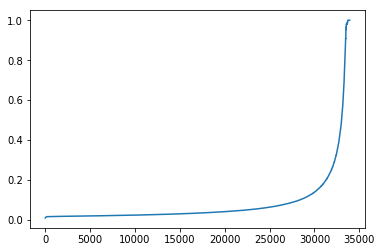

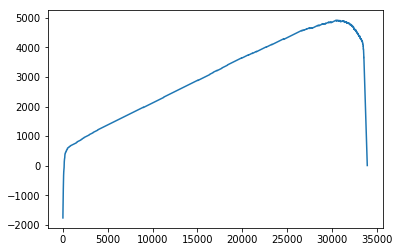

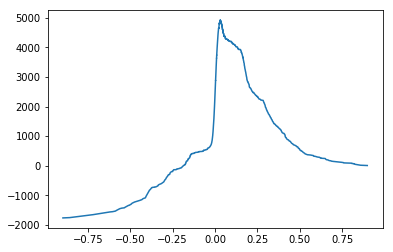

In [57]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

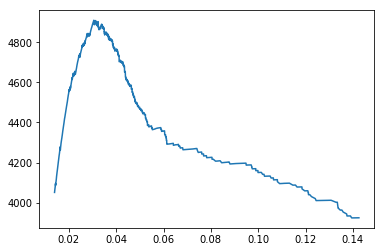

In [70]:
plt.plot(rec_y_promote[23000:33500], data_nir[23000:33500])
plt.show()

It dramatically overfits! I'm 100% going with OLS if it can pass... this one final test

In [158]:
y_test = pd.concat([X_testl['Promotion'], y_testl], axis=1)

In [33]:
incremental_score(y_test, clf.predict(X_testl))

0.008190747650313718

In [34]:
y_train_pred = clf.predict(X_trainl)

In [28]:
y_test_pred = clf.predict(X_testl)

In [29]:
y_test_pred.sum()

Promotion      YesNoNoNoYesYesYesYesNoNoNoYesYesYesNoNoYesNoY...
Recommended                                                 5829
dtype: object

In [107]:
y_for_analysis = y_test.copy()
y_for_analysis['Recommended'] = y_test_pred['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [108]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

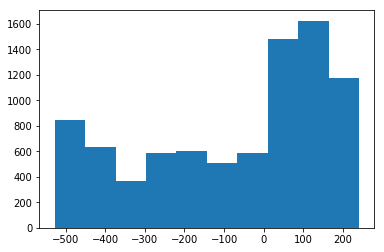

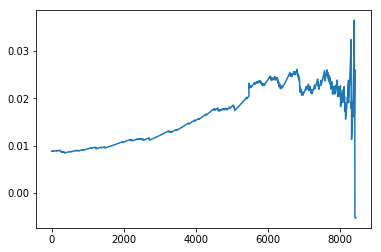

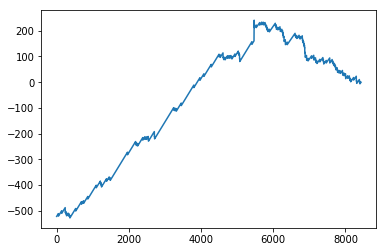

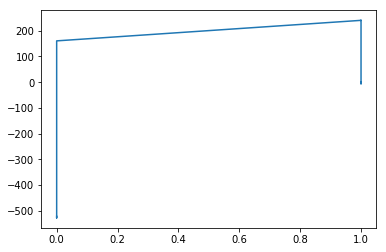

In [109]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

In [32]:
(incremental_score(y_test, y_test_pred) * 10 - 0.15) * y_test_pred['Recommended'].sum() 

-396.9113194632134

In [37]:
(incremental_score(y, y_train_pred) * 10 - 0.15) * y_train_pred['Recommended'].sum() 

-1688.5540886981883

In [148]:
clf.scorer_

make_scorer(incremental_score)

The data transformation part of the pipeline works fine! However, we have something of a complicated form of data here with a complex function to maximize. Given X_train data (within the promotion), we want to maximize net revenue. I could do this based on a slightly modified function, assuming the base rate. Then I just need to compare the rate within the class to the true rate. Could I also just directly maximize the response rate? Not really. irr is the key. But, if I split, the only thing I would need is to have y also splittable. Kind of annoying, right? Oh ho ho! So if we flip y_true when it comes to scores, I think we're golden. Then we maximize irr, and we can just graph nir on the best pipeline. Great!

In [19]:
class ProbabilityViaMean2(BaseEstimator):
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X0 = X[X['Promotion'] == 'No'].drop('Promotion', axis=1)
        X1 = X[X['Promotion'] == 'Yes'].drop('Promotion', axis=1)
        y0 = y[y['Promotion'] == 'No']['purchase']
        y1 = y[y['Promotion'] == 'Yes']['purchase']
        self.lrm0 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm1 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm0.fit(X0, y0)
        self.lrm1.fit(X1, y1)
        
    def predict(self, X):
        y = self.lrm1.predict(X.drop('Promotion', axis=1)) - self.lrm0.predict(X.drop('Promotion', axis=1))
        y_out = X.loc[:, ['Promotion']].copy()
        y_out['Recommended'] = y
        return y_out
        
    

In [112]:
class ProbabilityViaMean3(BaseEstimator, TransformerMixin):
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X0 = X[X['Promotion'] == 'No'].drop('Promotion', axis=1)
        X1 = X[X['Promotion'] == 'Yes'].drop('Promotion', axis=1)
        y0 = y[y['Promotion'] == 'No']['purchase']
        y1 = y[y['Promotion'] == 'Yes']['purchase']
        self.lrm0 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm1 = LinearRegression(fit_intercept=self.fit_intercept)
        self.lrm0.fit(X0, y0)
        self.lrm1.fit(X1, y1)
        return self
        
    def transform(self, X):
        y = self.lrm1.predict(X.drop('Promotion', axis=1)) - self.lrm0.predict(X.drop('Promotion', axis=1))
        X['Recommended'] = y
        return X

In [132]:
pipeline2 = Pipeline([
    ('featurizer', RegressionTransformer()),
    ('clf', ProbabilityViaMean2())
])

In [149]:
class MyClassifier(BaseEstimator):
    
    def __init__(self, cutoff=0.0075, class_weight='balanced', penalty='l2', loss='hinge', dual=True, fit_intercept=True, random_state=None):
        self.cutoff = cutoff
        self.class_weight = class_weight
        self.penalty = penalty
        self.loss = loss
        self.dual = dual
        self.fit_intercept = fit_intercept
        self.random_state = random_state

    def fit(self, X, y):
        X1 = X[X['Recommended'] > self.cutoff].drop('Promotion', axis=1)
        y1 = y[X['Recommended'] > self.cutoff].copy()
        y1['purchase'] = y1.apply(lambda row: row['purchase'] if row['Promotion'] == 'Yes' else 0, axis=1)
        y1 = y1['purchase']
        self.svc = LinearSVC(class_weight=self.class_weight, penalty=self.penalty, loss=self.loss, dual=self.dual, fit_intercept=self.fit_intercept, random_state=self.random_state)
        self.svc.fit(X1, y1)
        return self
        
    def predict(self, X):
        y = self.svc.predict(X.drop('Promotion', axis=1))
        y_out = X.loc[:, ['Promotion']].copy()
        y_out['do_promote'] = y
        return y_out
        
    

In [150]:
pipeline3 = Pipeline([
    ('featurizer', RegressionTransformer()),
    ('augment', ProbabilityViaMean3()),
    ('clf', MyClassifier())
])

In [151]:
pipeline3.get_params()

{'memory': None,
 'steps': [('featurizer',
   RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7'])),
  ('augment', ProbabilityViaMean3(fit_intercept=True)),
  ('clf', MyClassifier(class_weight='balanced', cutoff=0.0075, dual=True,
          fit_intercept=True, loss='hinge', penalty='l2', random_state=None))],
 'featurizer': RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']),
 'augment': ProbabilityViaMean3(fit_intercept=True),
 'clf': MyClassifier(class_weight='balanced', cutoff=0.0075, dual=True,
        fit_intercept=True, loss='hinge', penalty='l2', random_state=None),
 'featurizer__cat_cols': ['V1', 'V4', 'V5', 'V6', 'V7'],
 'augment__fit_intercept': True,
 'clf__class_weight': 'balanced',
 'clf__cutoff': 0.0075,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__loss': 'hinge',
 'clf__penalty': 'l2',
 'clf__random_state': None}

In [155]:
with_v1 = ['V1', 'V4', 'V5', 'V6', 'V7']
without_v1 = ['V4', 'V5', 'V6', 'V7']

parameters2 = {
#     'featurizer__cat_cols': [with_v1, without_v1],
    'clf__fit_intercept': [True, False],
}

In [35]:
def incremental_score(y_true, y_pred):
    base_rate = y_true[(y_true['Promotion'] == 'No') & (y_pred['Recommended'] > 0.015)]['purchase'].sum() / y_true[y_true['Promotion'] == 'No'].shape[0]
    promote_rate = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['Recommended'] > 0.015)]['purchase'].sum() / y_true[y_true['Promotion'] == 'Yes'].shape[0]
    inc_rate = promote_rate - base_rate
    return inc_rate

incremental_scorer = make_scorer(incremental_score)

In [87]:
def nir_score(y_true, y_pred):
    base_case = y_true[(y_true['Promotion'] == 'No') & (y_pred['do_promote'] == 1)]['purchase']
    promote_case = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['do_promote'] == 1)]['purchase']
    nir = my_nir(base_case, promote_case)
    return nir

nir_scorer = make_scorer(nir_score)

In [135]:
def nir_score2(y_true, y_pred):
    base_case = y_true[(y_true['Promotion'] == 'No') & (y_pred['Recommended'] > 0.015)]['purchase']
    promote_case = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['Recommended'] > 0.015)]['purchase']
    nir = my_nir(base_case, promote_case)
    return nir

nir_scorer2 = make_scorer(nir_score2)

In [152]:
with_v1 = ['V1', 'V4', 'V5', 'V6', 'V7']
without_v1 = ['V4', 'V5', 'V6', 'V7']

parameters3 = {
#     'featurizer__cat_cols': [with_v1, without_v1],
#     'clf__dual': [False, True],
#     'clf__penalty': ['l1', 'l2'],
#     'clf__loss': ['hinge', 'squared_hinge'],
    'clf__cutoff': [-1., 0., 0.005, 0.01, 0.015, 0.02]
}

In [92]:
y = pd.concat([X_trainl['Promotion'], y_trainl], axis=1)

In [154]:
clf3 = GridSearchCV(pipeline3, param_grid=parameters3, scoring=nir_scorer, return_train_score=True, cv=5)
clf3.fit(X_trainl, y)
clf3.cv_results_

{'mean_fit_time': array([3.78591833, 2.88922901, 2.1885704 , 1.67287235, 1.06889801,
        0.53170056]),
 'std_fit_time': array([0.08963477, 0.03397091, 0.03894944, 0.05831176, 0.0823119 ,
        0.08094891]),
 'mean_score_time': array([0.0287282 , 0.02844443, 0.02884345, 0.02911172, 0.03635688,
        0.02932134]),
 'std_score_time': array([0.00082049, 0.00095297, 0.00073539, 0.00075715, 0.01346476,
        0.0005563 ]),
 'param_clf__cutoff': masked_array(data=[-1.0, 0.0, 0.005, 0.01, 0.015, 0.02],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__cutoff': -1.0},
  {'clf__cutoff': 0.0},
  {'clf__cutoff': 0.005},
  {'clf__cutoff': 0.01},
  {'clf__cutoff': 0.015},
  {'clf__cutoff': 0.02}],
 'split0_test_score': array([ 141.47647059,  141.47647059,  141.47647059,  133.84615385,
          72.631961  , -222.90553561]),
 'split1_test_score': array([ 240.16391437,  240.16391437,  240.16391437,  188.354450

In [104]:
print(X_trainl.shape, y.shape)

(67627, 9) (67627, 2)


In [156]:
clf2 = GridSearchCV(pipeline2, param_grid=parameters2, scoring=nir_scorer2, return_train_score=True, cv=5)
clf2.fit(X_trainl, y)
clf2.cv_results_

{'mean_fit_time': array([0.07592459, 0.07523866]),
 'std_fit_time': array([0.00139567, 0.00104065]),
 'mean_score_time': array([0.02564368, 0.02533703]),
 'std_score_time': array([0.0009062 , 0.00025575]),
 'param_clf__fit_intercept': masked_array(data=[True, False],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__fit_intercept': True}, {'clf__fit_intercept': False}],
 'split0_test_score': array([129.17706093, 114.44084998]),
 'split1_test_score': array([203.82683616, 190.01728634]),
 'split2_test_score': array([98.19643423, 86.18842021]),
 'split3_test_score': array([ 29.80669371, -15.17678498]),
 'split4_test_score': array([227.2063685 , 213.22288557]),
 'mean_test_score': array([137.64353219, 117.73955145]),
 'std_test_score': array([71.63496369, 81.25719235]),
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_train_score': array([697.87598253, 623.51996419]),
 'split1_train_score': array([594.57180205, 604.41776662]),

In [110]:
y_pred_ols = clf2.predict(X_trainl)
y_pred_test_ols = clf2.predict(X_testl)

In [111]:
y_for_analysis = y.copy()
y_for_analysis['Recommended'] = y_pred_ols['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [112]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

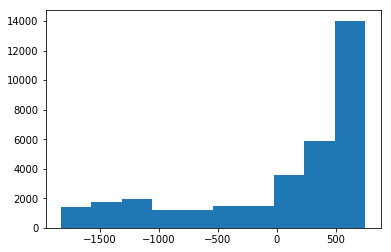

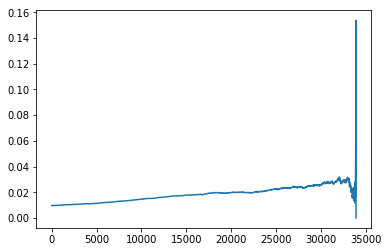

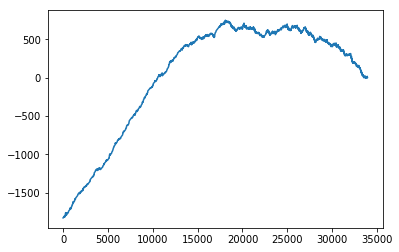

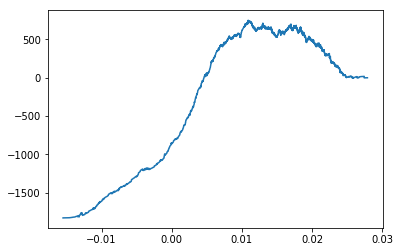

In [113]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

In [114]:
y_for_analysis = y_test.copy()
y_for_analysis['Recommended'] = y_pred_test_ols['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [115]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

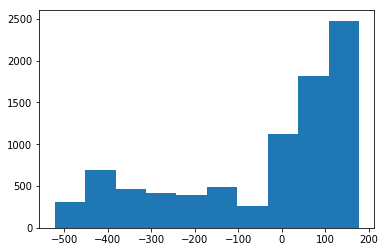

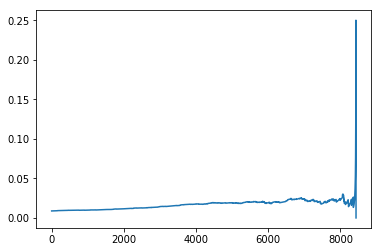

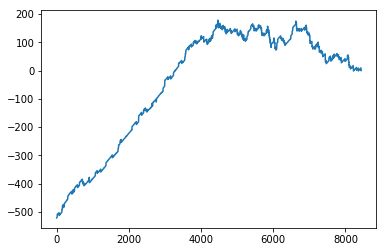

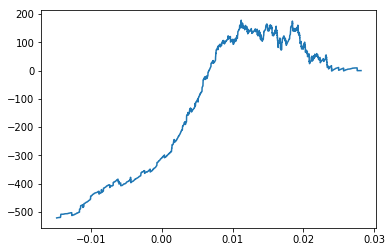

In [116]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

We need some inputs. This is a great prefiltering stage, even in test. What's more, it's quick and there's not that much tuning to be done. However, what can we do with this filtered data? At that point, maybe it's worth trying to tune a classifier with balanced weights. Or rather, why not just make this a feature engineering step?

In [21]:
class RegressionTransformer2(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X['V2'].to_numpy().reshape(-1, 1))
        return self

    def transform(self, X):
        cats = pd.get_dummies(X.loc[:, self.cat_cols], drop_first=True, columns=self.cat_cols)
        X = X.drop(self.cat_cols, axis=1)
        X = X.drop('ID', axis=1)
        X['V2'] = self.scaler.transform(X['V2'].to_numpy().reshape(-1, 1))[:, 0]
        X['purchase'] = X.apply(lambda row: row['purchase'] if row['Promotion'] == 'Yes' else row['purchase'] * -1.03, axis=1)
        X = pd.concat([X, cats], axis=1)
        return X


In [22]:
def jr_score(y_true, y_pred):
    base_rate = y_true[(y_true['Promotion'] == 'No') & (y_pred['Recommended'] > 0.)]['purchase'].sum() / y_true[y_true['Promotion'] == 'No'].shape[0]
    promote_rate = y_true[(y_true['Promotion'] == 'Yes') & (y_pred['Recommended'] > 0.)]['purchase'].sum() / y_true[y_true['Promotion'] == 'Yes'].shape[0]
    inc_rate = promote_rate - base_rate
    return inc_rate

jr_scorer = make_scorer(jr_score)

In [77]:
def transform_for_regression2(data, cat_cols=['V1', 'V4', 'V5', 'V6', 'V7']):
    data = data.copy()
    cats = pd.get_dummies(data.loc[:, cat_cols], drop_first=True, columns=cat_cols)
    data = data.drop(cat_cols, axis=1)
    data['V2'] = (data['V2'] - data['V2'].mean()) / data['V2'].std()
    data = pd.concat([data, cats], axis=1)
    data['purchase'] = data.apply(lambda row: row['purchase'] if row['Promotion'] == 'Yes' else row['purchase'] * -1, axis=1)
    return data

In [25]:
local_train_data.head()

,ID,Promotion,V1,V2,V3,V4,V5,V6,V7,purchase
66588,99250,Yes,3,34.470493,-1.078506,1,1,1,2,0
62125,92564,No,1,28.065819,-1.165083,1,1,3,1,0
27827,41307,Yes,1,27.142590,-1.511395,1,3,3,2,0
66648,99341,Yes,3,28.782344,-1.078506,1,1,1,2,0
47392,70517,No,2,39.605508,-0.645617,2,3,1,2,0


In [78]:
new_exp = transform_for_regression2(local_train_data)

In [29]:
new_exp.head(400).drop_duplicates(subset='purchase')

,ID,Promotion,V2,V3,purchase,V1_1,V1_2,V1_3,V4_2,V5_2,V5_3,V5_4,V6_2,V6_3,V6_4,V7_2
66588,99250,Yes,0.896915,-1.078506,0.00,0,0,1,0,0,0,0,0,0,0,1
33394,49666,Yes,0.248060,-0.645617,1.00,1,0,0,1,0,0,0,0,0,1,1
31595,46929,No,-0.094882,1.345672,-1.03,0,1,0,1,1,0,0,0,0,1,1


In [79]:
new_exp_X = new_exp.drop(['ID', 'Promotion'], axis=1)
new_exp_y = new_exp['purchase']

In [80]:
new_exp_lrm = LinearRegression()
new_exp_lrm.fit(new_exp_X, new_exp_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
new_exp_y_pred = new_exp_lrm.predict(new_exp_X)

In [82]:
(new_exp_y_pred > 0.).sum()

31445

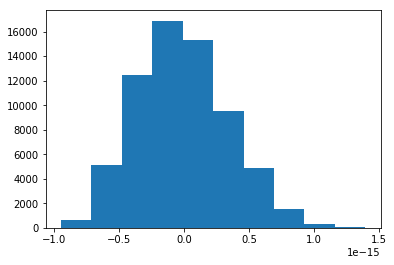

In [83]:
plt.hist(new_exp_y_pred[(new_exp_y_pred > -0.75) & (new_exp_y_pred < 0.75)])
plt.show()

In [84]:
def evaluate(y_true, rec_vals, y_promotions):
    y_for_analysis = pd.DataFrame(data={
        'purchase': y_true,
        'Recommended': rec_vals,
        'Promotion': y_promotions,
    })
    y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
    print(y_for_promotion.shape)
    print(y_for_promotion['purchase'].sum())
    y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
    print(y_for_control.shape)
    print(y_for_control['purchase'].sum())
    rec_y_promote = y_for_promotion['Recommended'].to_numpy()
    purch_y_promote = y_for_promotion['purchase'].to_numpy()
    rec_y_control = y_for_control['Recommended'].to_numpy()
    purch_y_control = y_for_control['purchase'].to_numpy()
    data_nir = np.zeros(rec_y_promote.size)
    data_irr = np.zeros(rec_y_promote.size)
    control_idx = 0
    for i in range(rec_y_promote.size):
        while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
            control_idx += 1
        print(control_idx, ':', purch_y_control[control_idx:].sum(), "vs", purch_y_promote[i:].sum())
        data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
        data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])
    plt.hist(data_nir)
    plt.show()
    plt.plot(data_irr)
    plt.show()
    plt.plot(data_nir)
    plt.show()
    plt.plot(rec_y_promote, data_nir)
    plt.show()

(33931, 3)
580
(33696, 3)
252
252 : 0 vs 580
252 : 0 vs 580
255 : 0 vs 580
255 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
256 : 0 vs 580
257 : 0 vs 580
258 : 0 vs 580
258 : 0 vs 580
259 : 0 vs 580
259 : 0 vs 580
259 : 0 vs 580
260 : 0 vs 580
262 : 0 vs 580
263 : 0 vs 580
264 : 0 vs 580
264 : 0 vs 580
266 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
268 : 0 vs 580
269 : 0 vs 580
271 : 0 vs 580
273 : 0 vs 580
275 : 0 vs 580
275 : 0 vs 580
275 : 0 vs 580
276 : 0 vs 580
276 : 0 vs 580
277 : 0 vs 580
277 : 0 vs 580
277 : 0 vs 580
279 : 0 vs 580
279 : 0 vs 580
279 : 0 vs 580
282 : 0 vs 580
282 : 0 vs 580
282 : 0 vs 580
284 : 0 vs 580
284 : 0 vs 580
285 : 0 vs 580
287 : 0 vs 580
288 : 0 vs 580
288 : 0 vs 580
289 : 0 vs 580
289 : 0 vs 580
290 : 0 vs 580
290 : 0 vs 580
291 : 0 vs 580
294 : 0 vs 580
294 : 0 vs 580
297 : 0 vs 580
297 : 0 vs 580
297 : 0 vs 580
297 : 0 vs 580
298 : 0 vs 580
301 : 0 vs 580
302 : 0 vs

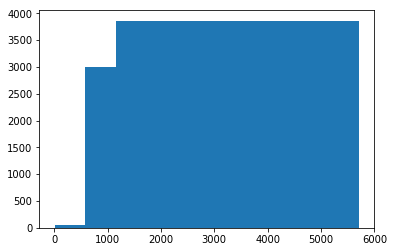

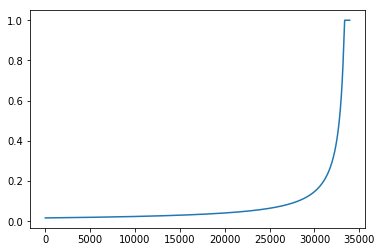

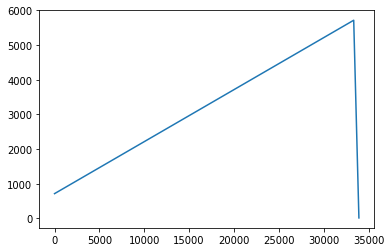

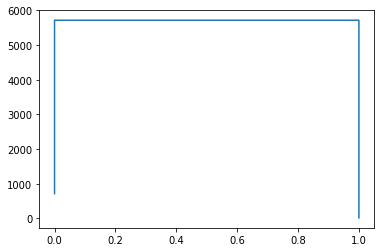

In [85]:
evaluate(local_train_data['purchase'], new_exp_y_pred, local_train_data['Promotion'])

In [48]:
y_for_analysis = y.copy()
y_for_analysis['Recommended'] = y_pred_2['Recommended']
y_for_promotion = y_for_analysis[y_for_analysis['Promotion'] == 'Yes'].sort_values(by='Recommended')
y_for_control = y_for_analysis[y_for_analysis['Promotion'] == 'No'].sort_values(by='Recommended')
rec_y_promote = y_for_promotion['Recommended'].to_numpy()
purch_y_promote = y_for_promotion['purchase'].to_numpy()
rec_y_control = y_for_control['Recommended'].to_numpy()
purch_y_control = y_for_control['purchase'].to_numpy()

In [54]:
data_nir = np.zeros(rec_y_promote.size)
data_irr = np.zeros(rec_y_promote.size)
control_idx = 0
for i in range(rec_y_promote.size):
    while control_idx < rec_y_control.size - 1 and rec_y_control[control_idx] < rec_y_promote[i]:
        control_idx += 1
    data_irr[i], _ = inc_resp_rate(purch_y_control[control_idx:], purch_y_promote[i:])
    data_nir[i] = my_nir(purch_y_control[control_idx:], purch_y_promote[i:])

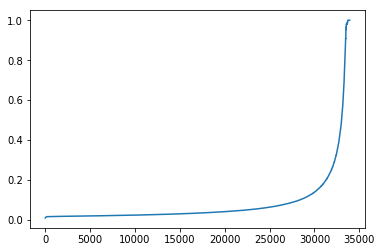

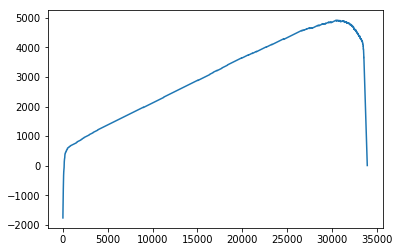

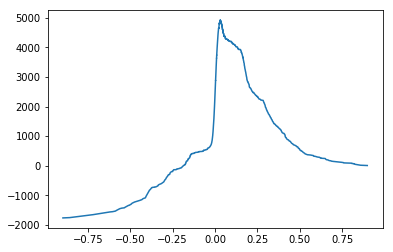

In [57]:
plt.hist(data_nir)
plt.show()
plt.plot(data_irr)
plt.show()
plt.plot(data_nir)
plt.show()
plt.plot(rec_y_promote, data_nir)
plt.show()

In [159]:
pipeline2.fit(X_trainl, y)
print(nir_score2(y_test, pipeline2.predict(X_testl)))

241.05157452764172


In [166]:
X_train

,ID,Promotion,V1,V2,V3,V4,V5,V6,V7
0,1,No,2,30.443518,-1.165083,1,1,3,2
1,3,No,3,32.159350,-0.645617,2,3,2,2
2,4,No,2,30.431659,0.133583,1,1,4,2
3,5,No,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,3,28.044332,-0.385883,1,1,2,2
...,...,...,...,...,...,...,...,...,...
84529,126180,No,1,30.084876,1.345672,1,1,3,1
84530,126181,Yes,3,33.501485,-0.299306,1,1,4,1
84531,126182,No,1,31.492019,1.085939,2,3,2,2
84532,126183,No,1,37.766106,0.999361,2,2,1,2


In [162]:
final_pipeline = pipeline2
y_final = pd.concat([X_train['Promotion'], y_train], axis=1)
final_pipeline.fit(X_train, y_final)

Pipeline(memory=None,
     steps=[('featurizer', RegressionTransformer(cat_cols=['V1', 'V4', 'V5', 'V6', 'V7'])), ('clf', ProbabilityViaMean2(fit_intercept=True))])

In [163]:
print(nir_score2(y_final, final_pipeline.predict(X_train)))

1076.046527626119


In [173]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df['Promotion'] = df.apply(lambda row: 'Yes', axis=1)
    df['ID'] = df.apply(lambda row: 1, axis=1)
    y_pred = final_pipeline.predict(df)
    promotion = y_pred['Recommended'].apply(lambda val: 'Yes' if val > 0.015 else 'No')
    
    
    return promotion

In [174]:
predicted = promotion_strategy(train_data.drop('purchase', axis=1))

In [176]:
y_pred_final = train_data.loc[:, ['Promotion']]
y_pred_final['do_promote'] = predicted.apply(lambda val: 1 if val == 'Yes' else 0)
print(nir_score(y_final, y_pred_final))

1076.046527626119


It works! We should be underfitting a bit, but this is what I got

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)